In this notebook, we compare the three models under a simple R&S setting.

Questions to answer before starting:
- Under what allocation strategy are we comparing these models?
- What is the ideal metric for comparison?

We could implement KG and use that for comparison. The predicted best arm
performance would then be the metric. It is not ideal, but since the KG
implementation is discussed in the paper for the unknown correlation model,
and it is supported via BoTorch for LCEGP, it is a feasible alternative.

For test function, we can train a GP model on a test function, and use the
posterior implied on a random set of points as the true underlying distribution.

In [1]:
from time import time

import torch
from botorch import fit_gpytorch_model, settings
from botorch.models import SingleTaskGP
from botorch.models.transforms import Standardize
from botorch.test_functions import EggHolder
from botorch.utils.transforms import unnormalize, t_batch_mode_transform
from gpytorch import ExactMarginalLogLikelihood
from gpytorch.distributions import MultivariateNormal

from contextual_rs.lce_gp import LCEGP
from contextual_rs.unknown_correlation_model import UnknownCorrelationModel
from contextual_rs.rs_kg import DiscreteKG, UnknownCorrelationKG

%matplotlib inline
import matplotlib.pyplot as plt

def get_random_posterior(
    num_alternatives: int,
    num_train: int = 100,
) -> MultivariateNormal:
    test_func = EggHolder(noise_std=0.1)
    t_X = torch.rand(num_train, test_func.dim)
    t_Y = test_func(unnormalize(t_X, test_func.bounds)).reshape(-1, 1)
    m = SingleTaskGP(t_X, t_Y, outcome_transform=Standardize(m=1))
    mll = ExactMarginalLogLikelihood(m.likelihood, m)
    fit_gpytorch_model(mll)
    post_X = torch.rand(num_alternatives, test_func.dim)
    post = m.posterior(post_X)
    return post

Let's compare the performance by optimizing via KG. The maximizer of the posterior
mean will be used as the predicted best arm.

Overwriting the random model with the MVN example from moment matching paper.

In [2]:
def model_constructor(model_type: str):
    def model_create(X, Y):
        if model_type == "LCEGP":
            model = LCEGP(
                X.view(-1, 1), Y.view(-1, 1), categorical_cols=[0], embs_dim_list=[2]
            )
            mll = ExactMarginalLogLikelihood(model.likelihood, model)
            fit_gpytorch_model(mll)
            return model
        else:
            model = UnknownCorrelationModel(X, Y, update_method=model_type)
            return model
    return model_create


def main_run(
    num_alternatives: int,
    rho: float,
    num_full_train: int,
    iterations: int,
    replications: int,
    skip_lce: int = 0,  # set 1 if we don't want to run LCEGP, else 0
):
    # sampling_post = get_random_posterior(num_alternatives)
    K = num_alternatives
    true_mean = torch.linspace(0, 1, K)
    true_cov = torch.zeros(K, K)
    for i in range(K):
        for j in range(K):
            true_cov[i, j] = torch.tensor(rho).pow(abs(i - j))
    sampling_post = MultivariateNormal(true_mean, true_cov)

    train_X = torch.arange(num_alternatives, dtype=torch.float).repeat(num_full_train)
    train_Y = sampling_post.rsample(torch.Size([num_full_train])).view(-1).detach()

    labels = ["LCEGP", "moment-matching", "KL", "moment-KL"]

    model_constructor_list = [
        model_constructor(m_type) for m_type in labels
    ]

    all_alternatives = torch.arange(num_alternatives, dtype=torch.float).view(-1, 1, 1)

    predicted_bests = [torch.zeros(replications, iterations) for _ in range(4)]
    start = time()

    for rep in range(replications):
        X_list = [train_X.clone() for _ in range(4)]
        Y_list = [train_Y.clone() for _ in range(4)]
        for i in range(iterations):
            if i == 0:
                print(f"Starting replication {rep}, iteration {i}, time: {time()-start}")
            next_points = torch.zeros(4)
            for j in range(skip_lce, 4):
                constructor = model_constructor_list[j]
                model = constructor(X_list[j], Y_list[j])

                if j:
                    predicted_bests[j][rep, i] = model.theta.argmax()
                    kg = UnknownCorrelationKG(
                        model=model
                    )
                    kg_vals = kg(None)
                else:
                    predicted_bests[j][rep, i] = model.posterior(all_alternatives).mean.argmax()
                    kg = DiscreteKG(
                        model=model
                    )
                    kg_vals = kg(all_alternatives)

                next_points[j] = kg_vals.argmax()

            full_eval = sampling_post.rsample().view(-1).detach()
            next_evals = full_eval[next_points.long()]

            for j in range(skip_lce, 4):
                X_list[j] = torch.cat([X_list[j], next_points[j].view(-1)], dim=-1)
                Y_list[j] = torch.cat([Y_list[j], next_evals[j].view(-1)], dim=-1)

    plot_values = [
        sampling_post.mean[tmp.long()].detach().mean(dim=0) for tmp in predicted_bests
    ]
    fig = plt.figure(figsize=(12, 8))
    fig.patch.set_facecolor('xkcd:mint green')

    for i in range(skip_lce, 4):
        plt.plot(plot_values[i], label=labels[i])
    plt.axhline(sampling_post.mean.max(), label="true_best")
    plt.grid()
    plt.legend()
    plt.show()

Starting replication 0, iteration 0, time: 0.00039005279541015625
Starting replication 1, iteration 0, time: 63.282358169555664
Starting replication 2, iteration 0, time: 129.9654679298401
Starting replication 3, iteration 0, time: 202.44412302970886
Starting replication 4, iteration 0, time: 262.9541609287262


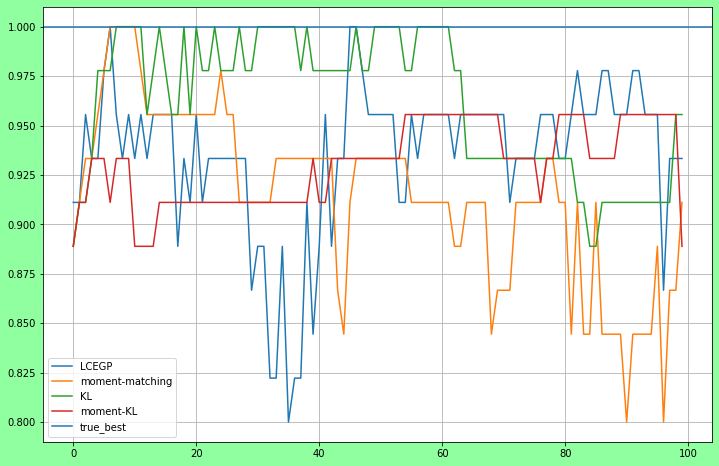

In [7]:
main_run(
    num_alternatives=10,
    rho=0.5,
    num_full_train=10,
    iterations=100,
    replications=5,
)

Starting replication 0, iteration 0, time: 2.9087066650390625e-05
Starting replication 1, iteration 0, time: 40.2401819229126
Starting replication 2, iteration 0, time: 74.0499210357666
Starting replication 3, iteration 0, time: 119.87970805168152
Starting replication 4, iteration 0, time: 157.03151202201843


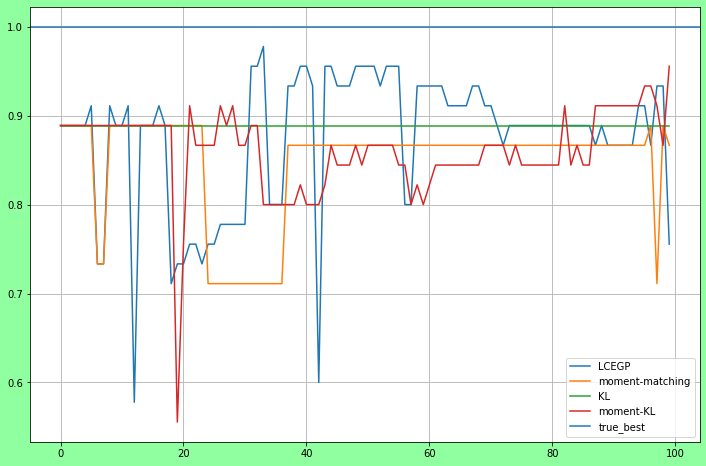

In [8]:
main_run(
    num_alternatives=10,
    rho=0.5,
    num_full_train=5,
    iterations=100,
    replications=5,
)

Starting replication 0, iteration 0, time: 3.0994415283203125e-05
Starting replication 1, iteration 0, time: 185.07958912849426
Starting replication 2, iteration 0, time: 356.93293595314026
Starting replication 3, iteration 0, time: 555.241907119751
Starting replication 4, iteration 0, time: 706.0289001464844


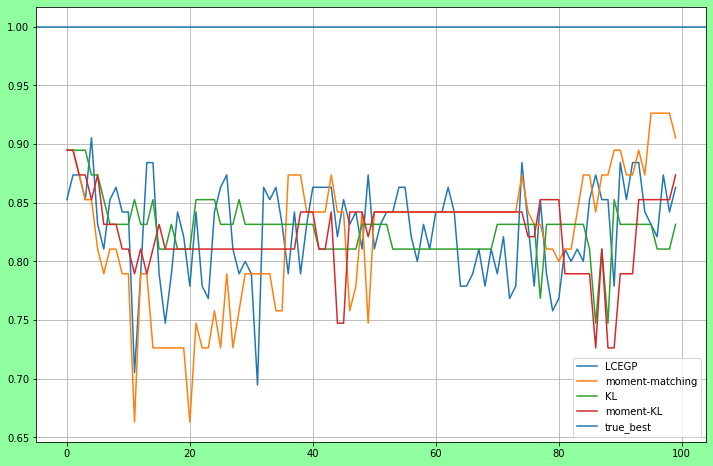

In [9]:
main_run(
    num_alternatives=20,
    rho=0.5,
    num_full_train=10,
    iterations=100,
    replications=5,
)

Starting replication 0, iteration 0, time: 6.794929504394531e-05
Starting replication 1, iteration 0, time: 147.52450442314148
Starting replication 2, iteration 0, time: 305.8408031463623
Starting replication 3, iteration 0, time: 465.9988532066345
Starting replication 4, iteration 0, time: 606.1442840099335


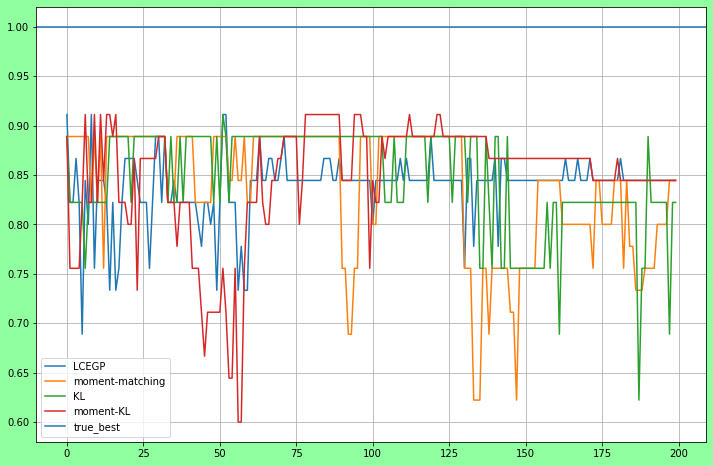

In [3]:
main_run(
    num_alternatives=10,
    rho=0.1,
    num_full_train=5,
    iterations=200,
    replications=5,
)

Starting replication 0, iteration 0, time: 4.506111145019531e-05
Starting replication 1, iteration 0, time: 166.8133990764618
Starting replication 2, iteration 0, time: 326.0433609485626
Starting replication 3, iteration 0, time: 493.98862314224243
Starting replication 4, iteration 0, time: 644.4042339324951


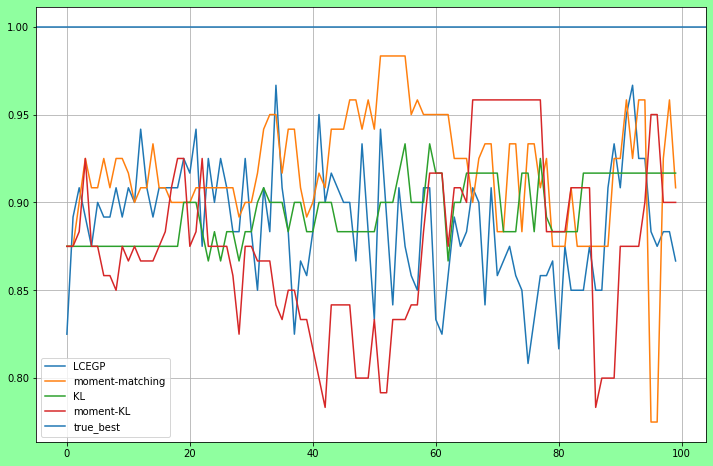

In [5]:
main_run(
    num_alternatives=25,
    rho=0.9,
    num_full_train=5,
    iterations=100,
    replications=5,
)

Starting replication 0, iteration 0, time: 3.4332275390625e-05
Starting replication 1, iteration 0, time: 151.7558238506317
Starting replication 2, iteration 0, time: 291.91502571105957
Starting replication 3, iteration 0, time: 452.49158549308777
Starting replication 4, iteration 0, time: 585.5749323368073


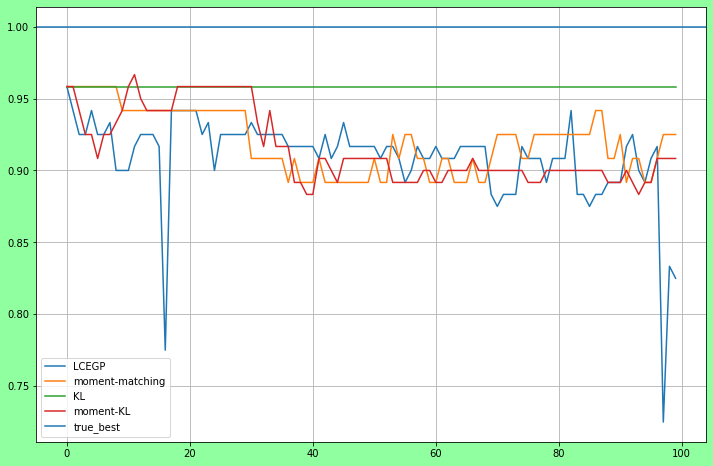

In [4]:
main_run(
    num_alternatives=25,
    rho=0.9,
    num_full_train=10,
    iterations=100,
    replications=5,
)

Starting replication 0, iteration 0, time: 4.696846008300781e-05
Starting replication 1, iteration 0, time: 139.77321910858154
Starting replication 2, iteration 0, time: 259.12531089782715
Starting replication 3, iteration 0, time: 359.34397411346436
Starting replication 4, iteration 0, time: 477.01574301719666
Starting replication 5, iteration 0, time: 591.0168118476868
Starting replication 6, iteration 0, time: 705.5189349651337
Starting replication 7, iteration 0, time: 818.8070781230927
Starting replication 8, iteration 0, time: 931.9882411956787
Starting replication 9, iteration 0, time: 1055.965343952179


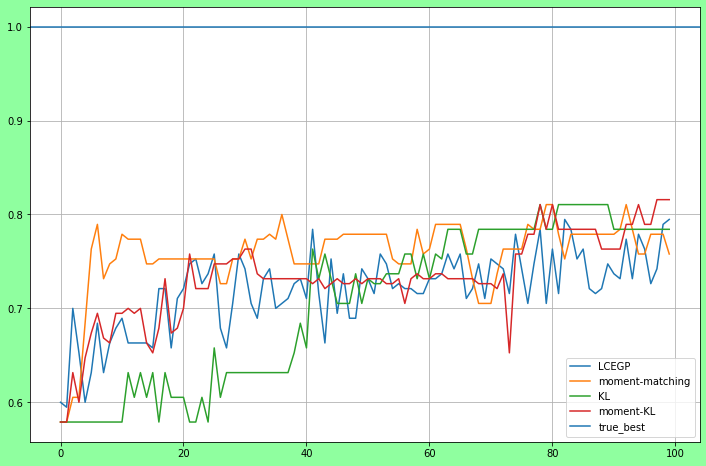

In [6]:
main_run(
    num_alternatives=20,
    rho=0.8,
    num_full_train=5,
    iterations=100,
    replications=10,
)

Starting replication 0, iteration 0, time: 3.361701965332031e-05
Starting replication 1, iteration 0, time: 304.939414024353
Starting replication 2, iteration 0, time: 590.9235372543335
Starting replication 3, iteration 0, time: 907.9853999614716
Starting replication 4, iteration 0, time: 1200.6087243556976
Starting replication 5, iteration 0, time: 1522.9941520690918
Starting replication 6, iteration 0, time: 1837.9186220169067
Starting replication 7, iteration 0, time: 2194.0204684734344
Starting replication 8, iteration 0, time: 2531.1066455841064
Starting replication 9, iteration 0, time: 2817.6119105815887


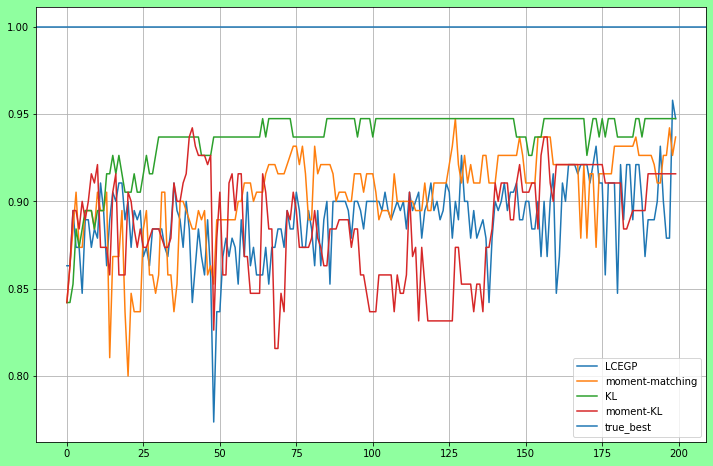

In [5]:
main_run(
    num_alternatives=20,
    rho=0.7,
    num_full_train=5,
    iterations=200,
    replications=10,
)

Starting replication 0, iteration 0, time: 0.0007579326629638672


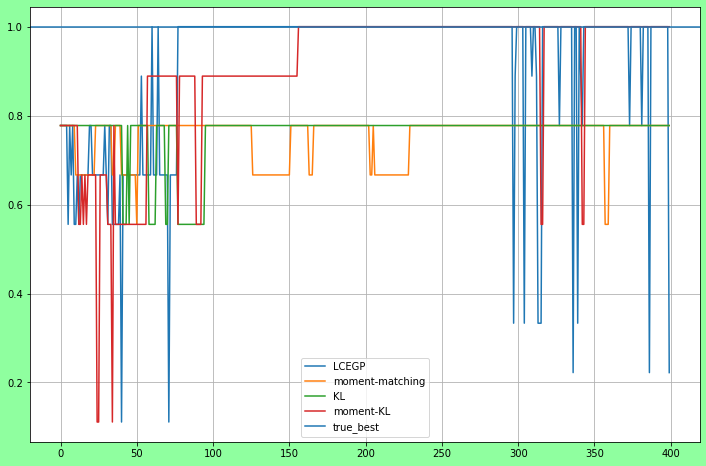

In [7]:
main_run(
    num_alternatives=10,
    rho=0.7,
    num_full_train=3,
    iterations=400,
    replications=1,
)

Starting replication 0, iteration 0, time: 0.0003097057342529297
Starting replication 1, iteration 0, time: 666.8914177417755
Starting replication 2, iteration 0, time: 1412.1428697109222
Starting replication 3, iteration 0, time: 2154.4908287525177
Starting replication 4, iteration 0, time: 2931.377607822418


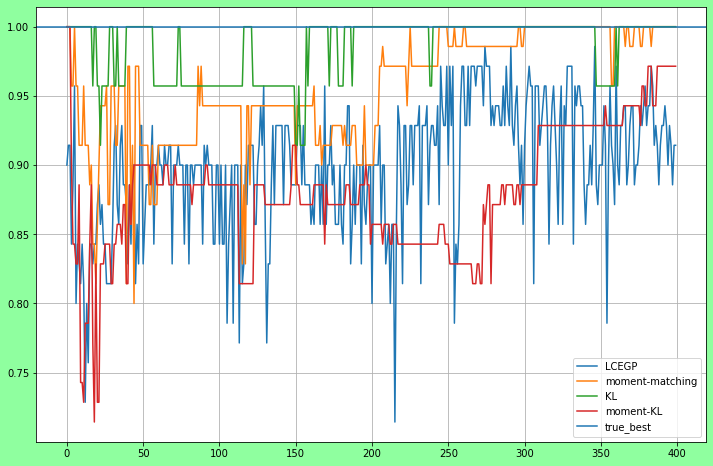

In [8]:
main_run(
    num_alternatives=15,
    rho=0.7,
    num_full_train=3,
    iterations=400,
    replications=5 ,
)

Starting replication 0, iteration 0, time: 5.340576171875e-05
Starting replication 1, iteration 0, time: 450.63725757598877
Starting replication 2, iteration 0, time: 892.3662993907928
Starting replication 3, iteration 0, time: 1325.301453113556
Starting replication 4, iteration 0, time: 1784.3334238529205


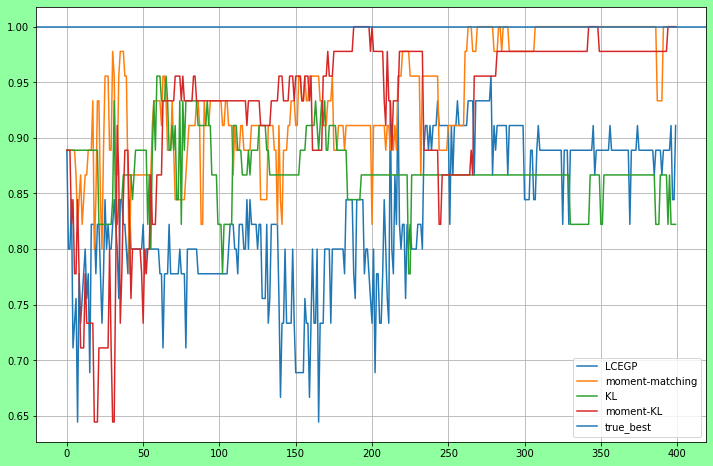

In [6]:
main_run(
    num_alternatives=10,
    rho=0.2,
    num_full_train=3,
    iterations=400,
    replications=5 ,
)

Starting replication 0, iteration 0, time: 0.00013875961303710938
Starting replication 1, iteration 0, time: 53.83245134353638
Starting replication 2, iteration 0, time: 77.70105838775635
Starting replication 3, iteration 0, time: 100.50440502166748
Starting replication 4, iteration 0, time: 125.11624026298523


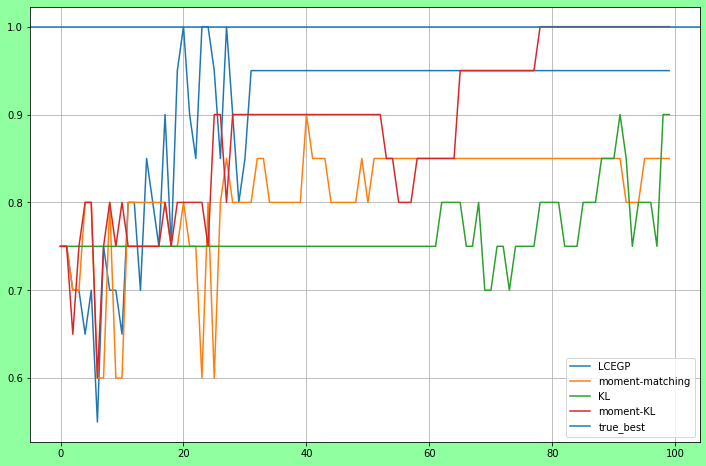

In [3]:
main_run(
    num_alternatives=5,
    rho=0.5,
    num_full_train=3,
    iterations=100,
    replications=5,
)

Starting replication 0, iteration 0, time: 3.62396240234375e-05
Starting replication 1, iteration 0, time: 321.8974325656891
Starting replication 2, iteration 0, time: 618.101536989212
Starting replication 3, iteration 0, time: 934.8771064281464
Starting replication 4, iteration 0, time: 1246.5029311180115


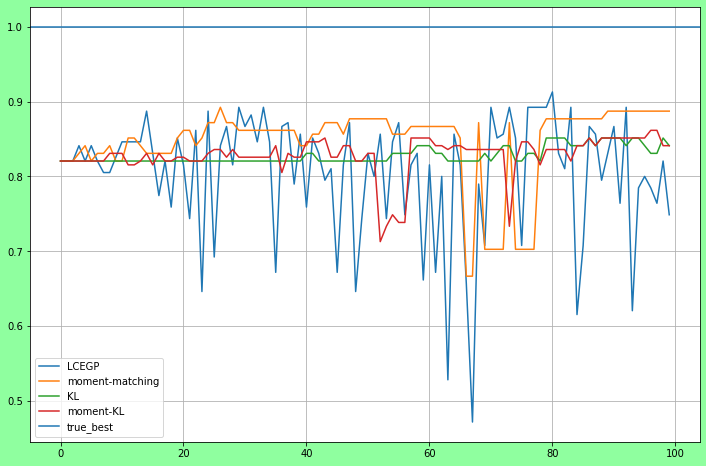

In [4]:
main_run(
    num_alternatives=40,
    rho=0.1,
    num_full_train=5,
    iterations=100,
    replications=5,
)


Starting replication 0, iteration 0, time: 8.058547973632812e-05
Starting replication 1, iteration 0, time: 70.5474636554718
Starting replication 2, iteration 0, time: 147.51048874855042
Starting replication 3, iteration 0, time: 215.45016050338745
Starting replication 4, iteration 0, time: 291.21694898605347
Starting replication 5, iteration 0, time: 370.3854990005493
Starting replication 6, iteration 0, time: 451.0442922115326
Starting replication 7, iteration 0, time: 529.9238181114197
Starting replication 8, iteration 0, time: 609.7123844623566
Starting replication 9, iteration 0, time: 672.3902609348297


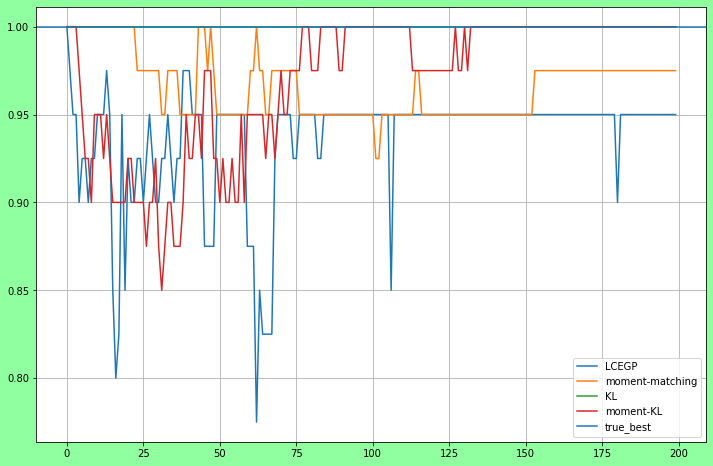

In [5]:
main_run(
    num_alternatives=5,
    rho=0.5,
    num_full_train=3,
    iterations=200,
    replications=10,
)

Starting replication 0, iteration 0, time: 3.695487976074219e-05
Starting replication 1, iteration 0, time: 91.62188816070557
Starting replication 2, iteration 0, time: 191.76447892189026
Starting replication 3, iteration 0, time: 275.9720690250397
Starting replication 4, iteration 0, time: 385.87437105178833
Starting replication 5, iteration 0, time: 484.98773527145386
Starting replication 6, iteration 0, time: 573.8738701343536
Starting replication 7, iteration 0, time: 668.566819190979
Starting replication 8, iteration 0, time: 777.0953912734985
Starting replication 9, iteration 0, time: 864.9755303859711


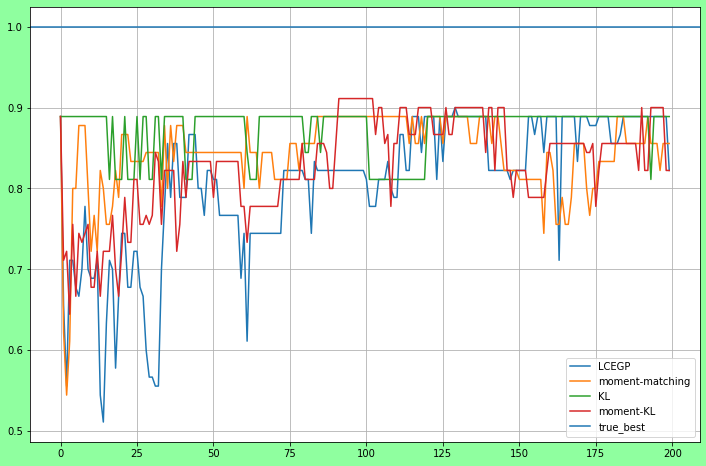

In [5]:
main_run(
    num_alternatives=10,
    rho=0.5,
    num_full_train=3,
    iterations=200,
    replications=10,
)

Starting replication 0, iteration 0, time: 9.322166442871094e-05


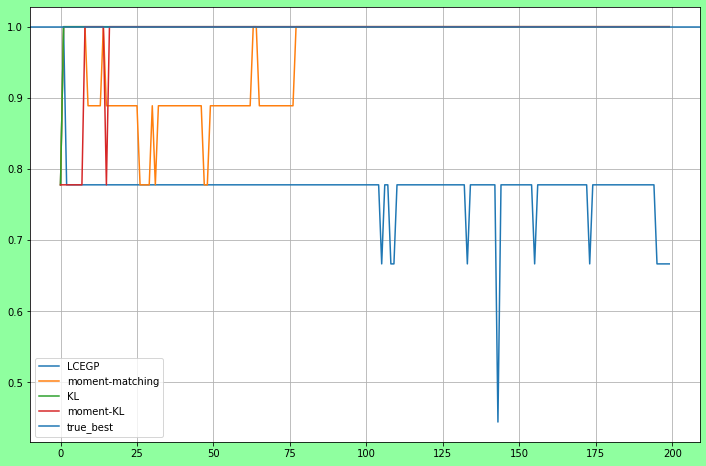

In [6]:
main_run(
    num_alternatives=10,
    rho=0.5,
    num_full_train=3,
    iterations=200,
    replications=1,
)